In [1]:
import jax
import jax.numpy as jnp
from jax import random, numpy as np, lax, vmap
import optax

key = jax.random.PRNGKey(42)

This post will serve two functions: to explain what a score function is, and to demonstrate the basics of JAX.

A score function is the gradient of the log probability density function with respect to the input.

$$ S(x) = \nabla_x \log p(x) $$

Surprisingly, [Hyvärinen et al.](http://jmlr.org/papers/v6/hyvarinen05a.html) showed we can estimate this function without knowing the density function $p(x)$ itself.

## How do we estimate it?

If we had the density, we could minimize the L2 loss between the true score function and our estimated score function $s_\theta(x)$ parameterized by $\theta$:

$$ \begin{align}
L(\theta) &= \frac{1}{2} \mathbb E_{x\sim p}\bigg[ || s_\theta(x) - \nabla_x \log p(x) ||^2_2 \bigg] \\
\end{align} $$

However, since we don't have the density , we can do some clever manipulation to remove this dependency.
$$
\begin{align*}
L(\theta) &= \frac{1}{2} \int p(x) || s_\theta(x) ||^2 dx - \underbrace{\int p(x) s_\theta(x)^T \nabla_x \log p(x) dx}_{\text{expanding log term}} + \frac{1}{2} \int p(x) || \nabla_x \log p(x) ||^2 dx \\
& \qquad  \qquad \qquad \qquad \qquad \qquad \qquad \qquad \Large\downarrow \\
&= \frac{1}{2} \int p(x) || s_\theta(x) ||^2 dx -
\underbrace{\left( \int \cancel {p(x)} s_\theta(x)^T \frac{\nabla_x p(x)}{\cancel{p(x)}}dx\right)}_{\text{multi-dimensional IBP where u= } s_\theta(x)^T, dv = \nabla_x p(x) dx}
+\frac{1}{2} \int p(x) || \nabla_x \log p(x) ||^2 dx \\
& \qquad  \qquad \qquad \qquad \qquad \qquad \qquad \qquad \Large\downarrow \\
&= \frac{1}{2} \int p(x) || s_\theta(x) ||^2 dx -
\left( \underbrace{s_\theta(x)^T p(x)\big|_{-\infty}^{\infty}}_{\text{boundary term}} - \int p(x) (\nabla_x \cdot s_\theta(x))dx\right)+
\underbrace{\frac{1}{2} \int p(x) || \nabla_x \log p(x) ||^2 dx}_{\text{constant w.r.t. } \theta} \\
&= \mathbb E_{x\sim p}\bigg[ \frac{1}{2} || s_\theta(x) ||^2 + Tr(\nabla_x s_\theta(x)) \bigg] + C
\end{align*}
$$

Great, now we can approximate the expectation with samples from $p(x)$ and minimize the loss using gradient descent! JAX is new to me, so the below is mainly about JAX, and future posts will be about the difficulties of score matching, which motivates diffusion models.

# Create Data

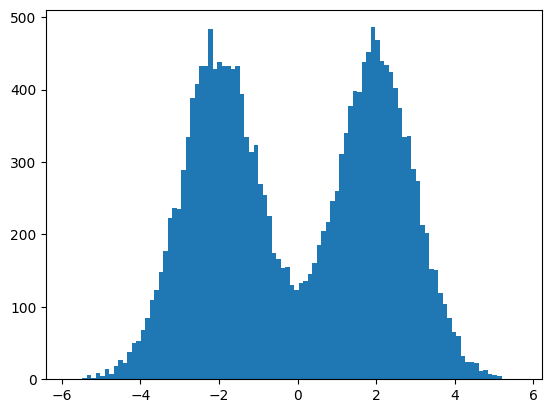

In [2]:
# create a mixture of gaussians
def create_dataset(mus,sigmas,ws,n_samples=20000):
  keys = jax.random.split(key, len(mus) + 1)
  samples = []
  for mu, sigma, w, current_key in zip(mus, sigmas, ws, keys):
    num_samples = int(n_samples * w)
    samples.append(random.normal(current_key, shape=(num_samples,)) * sigma + mu)
  return jnp.concatenate(samples)

mus = [-2,2]
sigmas = [1,1]
ws = [.5,.5]
dataset = create_dataset(mus,sigmas,ws)

# plot
import matplotlib.pyplot as plt
plt.hist(dataset,bins=100)
plt.show()

We have a created a simple 1D equal mixture of Gaussians.

The interesting part of this is to note is that JAX uses pure functions, which means

1. For the same input, the function will always return the same output
2. The function has no side effects (it doesn't modify any external state)

In this case, this poses a problem for random generation, since if we call random.normal with the same key for each Gaussian, we will get the same samples every time.
Instead, we have to explicitly get $\mu_1,...$ different keys by 'jax.random.split' because that is how many Gaussians we have in our mixture.

# Create MLP

In [3]:
szs = [1,1024]
out_dim = 1
szs = szs + [out_dim]
def create_mlp(szs):
  keys = random.split(key,len(szs))
  params = []
  for in_sz, out_sz, cur_key in zip(szs[:-1],szs[1:],keys):
    w_key, b_key = random.split(cur_key,2)
    w = random.normal(w_key,(in_sz,out_sz))
    b = random.normal(b_key,(out_sz,))
    params.append((w,b))
  return params

params = create_mlp(szs)

def relu(x):
  return jnp.maximum(0, x)

def forward(params, x):
  """
  params: list of weights and biases
  x: a single example of shape [feature_sz, ]
  """
  out = x
  for w,b in params[:-1]:
    out = jnp.dot(out,w) + b
    out = jax.nn.softplus(out)

  # output layer
  final_w, final_b = params[-1]
  out = jnp.dot(out,final_w) + final_b
  return out

Similarly to creating a random key for each Gaussian, we have to create a random key with \"random.split\" for each layer of the MLP, so each layer is not randomized to the same values.

## Loss Function and Gradient Calculation

There are two ways to calculate gradients from a mini-batch. We can calculate the gradient for each example in the batch, and then average the gradients. Alternatively, we can average the loss over the batch, and then take the gradient of that average loss. Both give the same gradients as the gradient of the average loss is the same as the average of the gradients. However, the former is more efficient, since it only requires one backward pass through the network, instead of one backward pass per example in the batch.

### Per-datapoint gradients (the inefficient way)

In [4]:
def score_matching_loss(params, x):
  """
  model: list of weights and biases
  x: shape [feature_sz,]
  """
  s_x = lambda x : forward(params, x)
  trace_term = jnp.trace(jax.jacfwd(s_x)(x))
  norm_term = .5 * jnp.sum(s_x(x))**2
  return trace_term + norm_term

model_to_loss_and_grad = jax.value_and_grad(score_matching_loss,argnums=0)

@jax.jit
def make_step(params, opt_state, batch):
  losses, grads = jax.vmap(model_to_loss_and_grad,in_axes=(None,0))(params, batch)
  # inaxes indicates to parallelize over the batch and use the same params for each

  loss = jnp.mean(losses)
  print(params)
  grad = jax.tree_util.tree_map(lambda g: jnp.mean(g, axis=0), grads)

  updates, opt_state = optimizer.update(grad, opt_state)
  params = optax.apply_updates(params, updates)
  return loss, params, opt_state

`vmap` will vectorize the provided function over the specified axis. Since I just learned about `vmap`, my first thought was to create a loss function that would work for one example, and then vectorize over the batch. In this case, we want to vectorize over the batch axis (the 0th axis) of the input data, while keeping the model parameters the same for each datapoint in the batch (hence `in_axes=(None, 0)`).

But, we also want the gradient, not just the loss. The `value_and_grad` function computes both the value of the loss function and its gradient with respect to the model parameters. `argnums` indicates what input variable(s) of a function will be differentiated wrt. In our case, we explictly indicates that we want to differentiate with respect to the model parameters with `argnums=0`. If you pass in a tuple, then you will get a tuple of gradients. By using `vmap`, we apply this function to each example in the batch, resulting in a list of losses and gradients.

However, this is inefficient, since it requires one backward pass per example in the batch. Interestingly, this also exposed me to another JAX concept, Pytrees, when trying to compute the average gradient. Pytrees are nested structures of python containers (like lists, tuples, and dictionaries), called branches, that can hold data (like arrays or scalars) at the leaves. In our case, the model parameters $[(w1,b1), (w2,b2), \dots]$ are a list of tuples, so the outer list is a branch, and each tuple is a nested branch, with the weights and biases as leaves.

Pytrees give us the flexibility to do handy operations like `vmap,grad,etc` on complex data structures, like `params`. However, this means we cannot just call `jnp.mean(grads)` because the gradients will also be a nested list of tuples, an undefined operation. More specifically, the data at the leaves of the gradients will have an extra batch dimension, since we calculated the gradient for each example in the batch. We extract the mean over this batch dimension for each leaf in the nested structure by using `jax.tree_util.tree_map`, which walks though the entire PyTree, applying a function we specificy to each leaf. This is exactly `lambda g: jnp.mean(g, axis=0)`.

### Per-batch gradient (the efficient way)

In [5]:
def score_matching_loss(params, x):
  """
  model: list of weights and biases
  x: shape [feature_sz,]
  """
  s_x = lambda x : forward(params, x)
  trace_term = jnp.trace(jax.jacfwd(s_x)(x))
  norm_term = .5 * jnp.sum(s_x(x))**2
  return trace_term + norm_term

def batch_loss(params, batch):
  # inaxes indicates to parallelize loss calculation over the batch and use the same params for each
  return jnp.mean(jax.vmap(score_matching_loss,in_axes=(None,0))(params, batch))

@jax.jit
def make_step(params, opt_state, batch):
  loss, grad = jax.value_and_grad(batch_loss)(params, batch)

  updates, opt_state = optimizer.update(grad, opt_state)
  params = optax.apply_updates(params, updates)
  return loss, params, opt_state

Now, that we've seen the inefficient approach, we can see that the efficient approach is much simpler. We just need to create a `batch_loss` function that averages the loss over the batch by using `vmap` to vectorize the `score_matching_loss` function over the batch axis of the input data (again using `in_axes=(None, 0)`). Then, we can use `value_and_grad` on this `batch_loss` function to get the loss and gradient in one backward pass.

It is worth noting `grad` is still a PyTree, but since we only calculated one gradient for the entire batch, there is no extra batch dimension to average over. This means its PyTree structure $[\text{(grad_w1,grad_b1),(grad_w2,grad_b2)}]$ is the same as `params`, so we can directly use it in `optax.apply_updates`, which requires the gradient to have the same structure as the parameters.

# Main Training Loop

In [6]:
learning_rate = 5e-3
epochs = 500
batch_size = 2048
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

In [7]:
model_key, train_key = random.split(key,2)
num_batches = len(dataset) // batch_size
losses = []
for epoch in range(epochs):
  mb_losses = []
  for i in range(num_batches):
    train_key, choice_key, step_key = random.split(train_key,3)
    indices = random.choice(choice_key,len(dataset),shape=(batch_size,),replace=False)
    batch = dataset[indices]

    loss, params, opt_state = make_step(params, opt_state, batch)
    mb_losses.append(loss)
  loss = jnp.mean(jnp.array(mb_losses))
  losses.append(loss)
  print(f'Epoch: {epoch}, Loss: {loss}')

Epoch: 0, Loss: 3177.72265625
Epoch: 1, Loss: 211.29458618164062
Epoch: 2, Loss: 291.1797790527344
Epoch: 3, Loss: 121.80747985839844
Epoch: 4, Loss: 24.00171661376953
Epoch: 5, Loss: 30.262611389160156
Epoch: 6, Loss: 5.925556182861328
Epoch: 7, Loss: 5.7019453048706055
Epoch: 8, Loss: 1.3145476579666138
Epoch: 9, Loss: 1.019349217414856
Epoch: 10, Loss: 0.1265537291765213
Epoch: 11, Loss: -0.02911228872835636
Epoch: 12, Loss: -0.1976195126771927
Epoch: 13, Loss: -0.22964665293693542
Epoch: 14, Loss: -0.2720133364200592
Epoch: 15, Loss: -0.2750064432621002
Epoch: 16, Loss: -0.29703372716903687
Epoch: 17, Loss: -0.28125348687171936
Epoch: 18, Loss: -0.29429832100868225
Epoch: 19, Loss: -0.2701902389526367
Epoch: 20, Loss: -0.27173498272895813
Epoch: 21, Loss: -0.2711723744869232
Epoch: 22, Loss: -0.2721530497074127
Epoch: 23, Loss: -0.2969388961791992
Epoch: 24, Loss: -0.2988685071468353
Epoch: 25, Loss: -0.29066142439842224
Epoch: 26, Loss: -0.2817121148109436
Epoch: 27, Loss: -0.2844

The only interesting part of the training loop is how we create the mini-batches. Again, since JAX uses pure functions, we have to explicitly split the random key at each step to get a new key for generating random indices for the mini-batch.

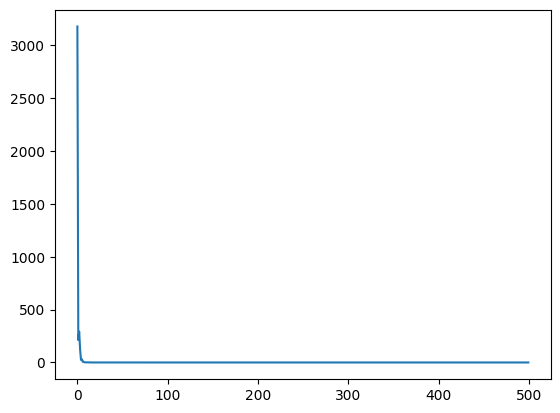

In [8]:
# plot loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

## True vs Expected Score

In [13]:
from jax import grad
from jax.scipy.stats import norm # Use JAX's SciPy stats for compatibility
import matplotlib.pyplot as plt


def mixture_norm_pdf(x, mus, sigmas, ws):
    mus = jnp.array(mus)
    sigmas = jnp.array(sigmas)
    ws = jnp.array(ws)

    pdf_values = ws * norm.pdf(x, loc=mus, scale=sigmas)

    return jnp.sum(pdf_values)

xs = jnp.arange(-4,4,.01)

# Calculate the true score function (gradient of log PDF)
def mixture_norm_log_pdf(x, mus, sigmas, ws):
    return jnp.log(mixture_norm_pdf(x, mus, sigmas, ws))

# Use jacfwd for scalar function and vmap for batching
true_score = vmap(jax.jacfwd(mixture_norm_log_pdf,argnums=0), in_axes=(0, None, None, None))

We know the true density function of our mixture of Gaussians, so we can calculate the true score function by taking the gradient of the log density function. First, we calculate the log PDF of the mixture of Gaussians, and then we use `jax.jacfwd` to take the gradient of this scalar function. Since we want to calculate the score function for multiple values of x, we use `vmap` to vectorize this gradient function over the input x values.

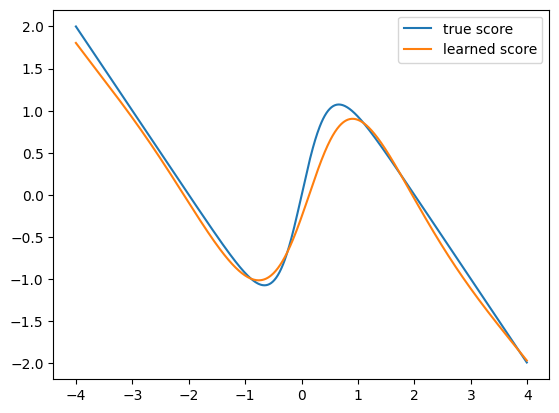

In [14]:
plt.plot(xs,true_score(xs, mus, sigmas, ws),label='true score')
plt.plot(xs,vmap(forward,in_axes=(None,0))(params,xs).squeeze(-1),label='learned score')

plt.legend()
plt.show()

Great news! Our learned score function matches the true score function pretty well on this 1d toy dataset. We will see how this falls apart in our next blog post with high dimensional data.

# Sampling with Langevin Dynamics

The scores tell us the direction of increasing likelihood, but that following this from some initial $x_0$ will result in deterministic sampling. As a result, we follow the 'noisy' scores. This is called Langevin dynamics. When run for long enough with small enough steps, $x_t \sim p(x)$.

$$ x_{t+1} = x_t + \alpha_t \nabla_x \log p(x_t) + \sqrt{2\alpha} z_t, \quad z_t \sim \mathcal N(0, I) $$

Since we don't have the true score function, we will use our learned score function instead.

$$ x_{t+1} = x_t + \alpha_t s_\theta(x_t) + \sqrt{2\alpha} z_t, \quad z_t \sim \mathcal N(0, I) $$


In [10]:
alpha = 1e-2
n_particles = 10000
n_samples = 1000

def f(prev,key):
  epsilon = random.normal(key,shape=prev.shape)
  return prev + alpha*forward(params,prev)[0][0] + np.sqrt(2 * alpha)*epsilon, prev

def g(x,key):
  keys = random.split(key,n_samples)
  # in jax, functions must be pure, for the same key, random.normal must always return the same number
  # so we create an array of n_samples keys so that each step of langevin sampling, we get a new epsilon
  res, history = lax.scan(f,init=x,xs=keys)
  return res, history


xs = random.uniform(key,shape=(n_particles,))
keys = random.split(key,n_particles)
res, history = vmap(g)(xs,keys)

lax.scan is a handy function that allows us to carry state through a loop. In our case, we want to carry the current position of the particles through the Langevin dynamics steps. The `f` function is one step of Langevin dynamics. The `g` function runs `n_samples` steps of Langevin dynamics for one particle, using `lax.scan` to carry the state through the steps.  `lax.scan()` takes three arguments: the function to apply at each step, the initial state `init`, and the sequence of inputs `xs` (data each timestep we want to reference) as we iterate. We can write f(carry,x)->(carry,y), where carry is the state we want to carry through the loop, x is the input at the current step, and y is the output at the current step.

In our case, `lax.scan()` will call `f`, `n_samples` times, passing the output of one step of Langevin dynamics as the input to the next call (the carry). The `xs` argument is an array of keys, one for each step, so that we can get a new random epsilon at each step. The `init` argument is the initial position of the particle. It returns the final position of the particle and the history of positions.

Since we want to run this for multiple particles, we use `vmap` to vectorize the `g` function over different initial positions.

The only wrinkle is that we need a new random key for each step of Langevin dynamics to get distinct epsilon for a particle over time and that this epsilon is distinct across particles as well. The latter is fulfilled by creating `n_particles` keys, feeding this into `g`, which creates `n_samples` child keys (number of Langevin steps) in `f` for each particle, fulfilling the former requirement.

That is why `vmap(g)` is called over the particles and keys.

## Visualize Evolution

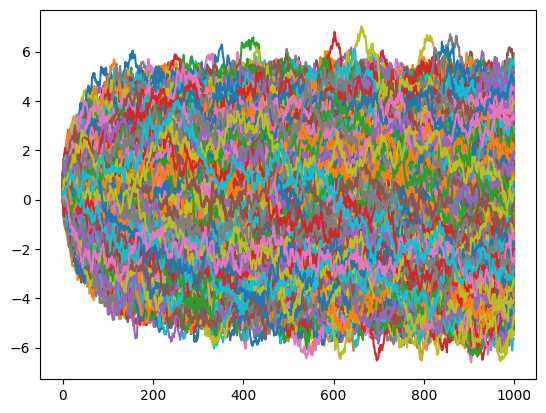

In [11]:
# plot history of each evolution (second dim)
import matplotlib.pyplot as plt
for i in range(history.shape[0]):
  plt.plot(history[i,:,])
plt.show()

## Visualize Samples

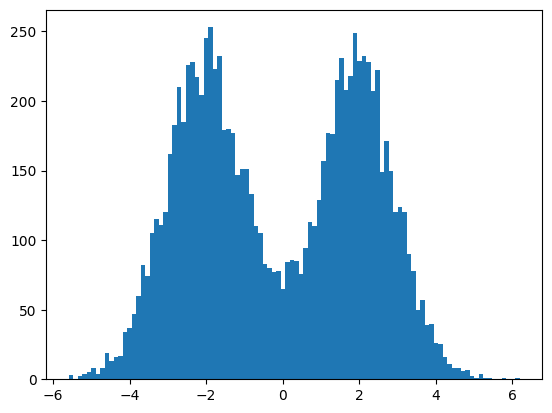

In [12]:
# plot final samples
import matplotlib.pyplot as plt
plt.hist(res[:],bins=100)
plt.show()